### Forecast de demanda: Facturapp

### ✅ Prophet

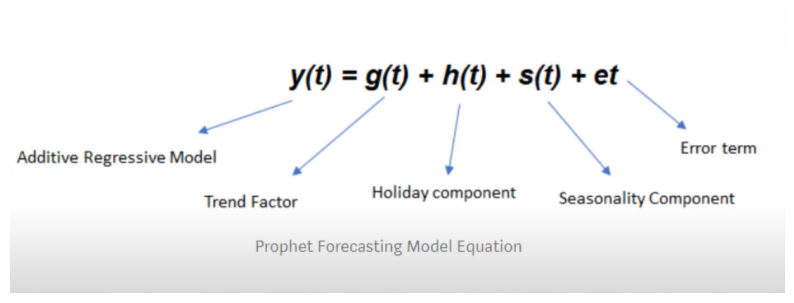

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/04_Prophet/Prophet forecasting model equation.PNG')

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()


##### Datos

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [2]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [6]:
import pandas as pd

# Suponiendo que 'ventas' tiene las columnas 'producto_id' y 'cantidad_vendida'
# Sumar las ventas por producto
ventas_totales = ventas_df.groupby('codigo_producto')['cantidad_ventas_producto'].sum().reset_index()

# Ordenar por la cantidad total vendida en orden descendente
ventas_totales = ventas_totales.sort_values(by='cantidad_ventas_producto', ascending=False)

# Seleccionar el top 10 de productos más vendidos
top_10_productos = ventas_totales.head(10)

# Si quieres agregar el nombre del producto del DataFrame 'productos'
top_10_productos = top_10_productos.merge(productos_df[['codigo_producto', 'descripcion_producto']], on='codigo_producto')

# Mostrar los resultados
top_10_productos

,codigo_producto,cantidad_ventas_producto,descripcion_producto
0,108681,268839.0,LECHE ENTERA SIN FRIO PARMALAT 1 LT
1,1238,76243.0,MAYONESA URUGUAY 125 GR (20 UNI)
2,108687,49591.0,CHOCOLATADA SIN FRIO PARMALAT 1 LT
3,108682,28726.0,LECHE DESCREMADA SIN FRIO PARMALAT 1 LT
4,123,25556.0,ARROZ CHEF 1 KG (20 UNI)
5,6018,23657.0,LEVADURA FRESCA LEVASAF 500GR (20 UNI)
6,108604,22875.0,LECHE ENTERA PARMALAT 1 LT
7,5576,22569.0,CAJA CHIVITO CHICA (50 UNI)
8,250,19743.0,YOGUR BEBIBLE FRUTILLA 1 LT
9,251,18975.0,YOGUR BEBIBLE DURAZNO 1 LT


In [7]:
# Lista de códigos de producto que quieres filtrar
codigos_producto = ['108681', '1238', '108687', '108682', '123', '6018', '108604', '5576', '250', '251']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_prophet = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

df_prophet = df_prophet[['fecha_venta', 'cantidad_ventas_producto']]

# Renombramos variables para que prophet tome como input
df_prophet = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df_prophet.head()

,ds,y
0,2022-04-16,14.0
1,2022-04-17,70.0
2,2022-04-18,1222.0
3,2022-04-19,701.0
4,2022-04-20,517.0


##### Para modelar vacaciones y eventos especiales con selección manual

In [ ]:
#playoffs = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})
#superbowls = pd.DataFrame({
#  'holiday': 'superbowl',
#  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})
#holidays = pd.concat((playoffs, superbowls))

In [ ]:
# Para ver qué días festivos se incluyen
# m.train_holiday_names

##### Train Model

In [46]:
from prophet import Prophet

m = Prophet(
    growth='linear',  # Define el tipo de tendencia de crecimiento. "linear" (predeterminado) o "logistic".

    changepoints=None,  # Lista de fechas donde se espera que la tendencia cambie. None para detección automática.
    
    n_changepoints=25,  # Número de puntos de cambio a ser detectados automáticamente. El valor predeterminado es 25.
    
    changepoint_range=0.8,  # Proporción del historial en el que se detectan los puntos de cambio. El valor predeterminado es 0.8 (80% del historial).
    
    yearly_seasonality='auto',  # Controla la estacionalidad anual. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    weekly_seasonality='auto',  # Controla la estacionalidad semanal. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    daily_seasonality=True,  # Controla la estacionalidad diaria. Puede ser True, False, un entero o 'auto' (predeterminado).
    
    holidays=None,  # DataFrame con las fechas de los días festivos a incluir en el modelo. None para no incluir días festivos.

    seasonality_mode='additive',  # Define el modo de estacionalidad: 'additive' (predeterminado) o 'multiplicative'.
    
    seasonality_prior_scale=10.0,  # Controla la regularización de la estacionalidad. El valor predeterminado es 10.0.
    
    holidays_prior_scale=10.0,  # Controla la regularización de los efectos de días festivos. El valor predeterminado es 10.0.
    
    changepoint_prior_scale=0.05,  # Controla la regularización de los puntos de cambio en la tendencia. El valor predeterminado es 0.05.
    
    mcmc_samples=0,  # Número de muestras MCMC para la estimación de la incertidumbre. El valor predeterminado es 0 (no se utiliza MCMC).
    
    interval_width=0.95,  # Ancho del intervalo de incertidumbre. El valor predeterminado es 0.80, aquí se configura al 95%.
    
    uncertainty_samples=1000,  # Número de muestras para la estimación de incertidumbre posterior. El valor predeterminado es 1000.
    
    stan_backend=None  # Backend a utilizar para las muestras MCMC. Puede ser 'CMDSTANPY', 'PYRO', o None (utiliza el predeterminado).
)

m.add_country_holidays(country_name='UY')

model = m.fit(df_prophet)

00:01:11 - cmdstanpy - INFO - Chain [1] start processing
00:01:11 - cmdstanpy - INFO - Chain [1] done processing


#### Make Predictions

In [47]:
future = m.make_future_dataframe(periods=100, freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Constitution Day,Constitution Day_lower,Constitution Day_upper,Day of the Family,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-04-18,1.566284,-3.765515,7.790209,1.566284,1.566284,0.0,0.0,0.0,0.0,...,-1.598634,-1.598634,-1.598634,-0.210324,-0.210324,-0.210324,0.0,0.0,0.0,2.026551
1,2022-04-20,1.563922,-1.832138,9.828351,1.563922,1.563922,0.0,0.0,0.0,0.0,...,0.346797,0.346797,0.346797,-0.063235,-0.063235,-0.063235,0.0,0.0,0.0,4.116708
2,2022-04-21,1.562740,-1.986294,9.317359,1.562740,1.562740,0.0,0.0,0.0,0.0,...,-0.200178,-0.200178,-0.200178,0.008490,0.008490,0.008490,0.0,0.0,0.0,3.640276
3,2022-04-22,1.561559,0.043095,11.761694,1.561559,1.561559,0.0,0.0,0.0,0.0,...,1.798906,1.798906,1.798906,0.078080,0.078080,0.078080,0.0,0.0,0.0,5.707769
4,2022-04-23,1.560378,-1.355176,9.843265,1.560378,1.560378,0.0,0.0,0.0,0.0,...,0.849204,0.849204,0.849204,0.144801,0.144801,0.144801,0.0,0.0,0.0,4.823607


In [48]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
319,2024-08-29,3.156027,-2.001757,9.090067
320,2024-08-30,5.026390,-0.589061,10.980498
321,2024-08-31,3.940453,-1.840530,9.881755
322,2024-09-01,2.665423,-3.118360,7.780813
323,2024-09-02,1.204041,-4.754460,7.244530


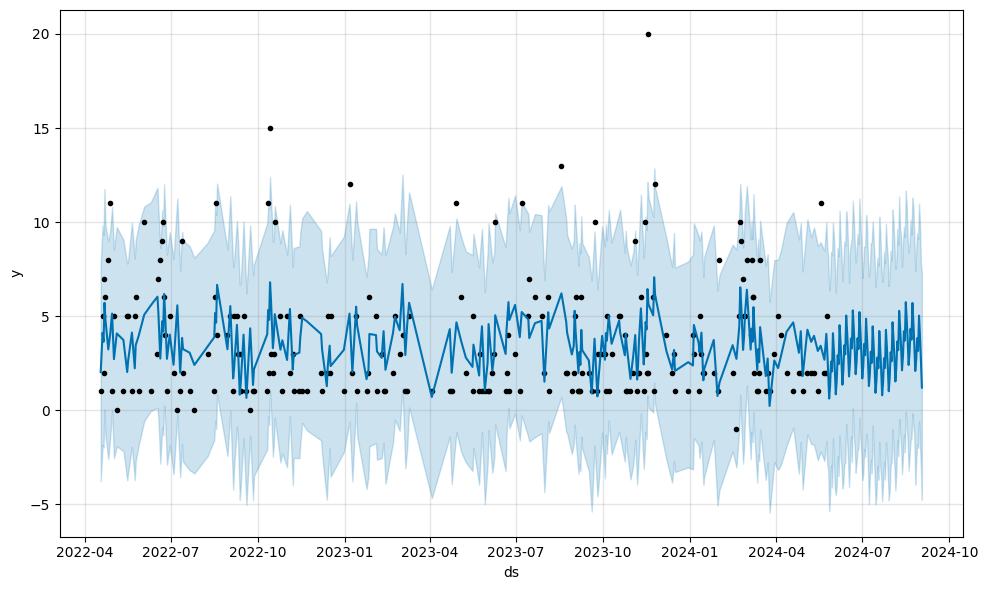

In [49]:
# Grafica las predicciones junto con el historial
fig1 = m.plot(forecast)

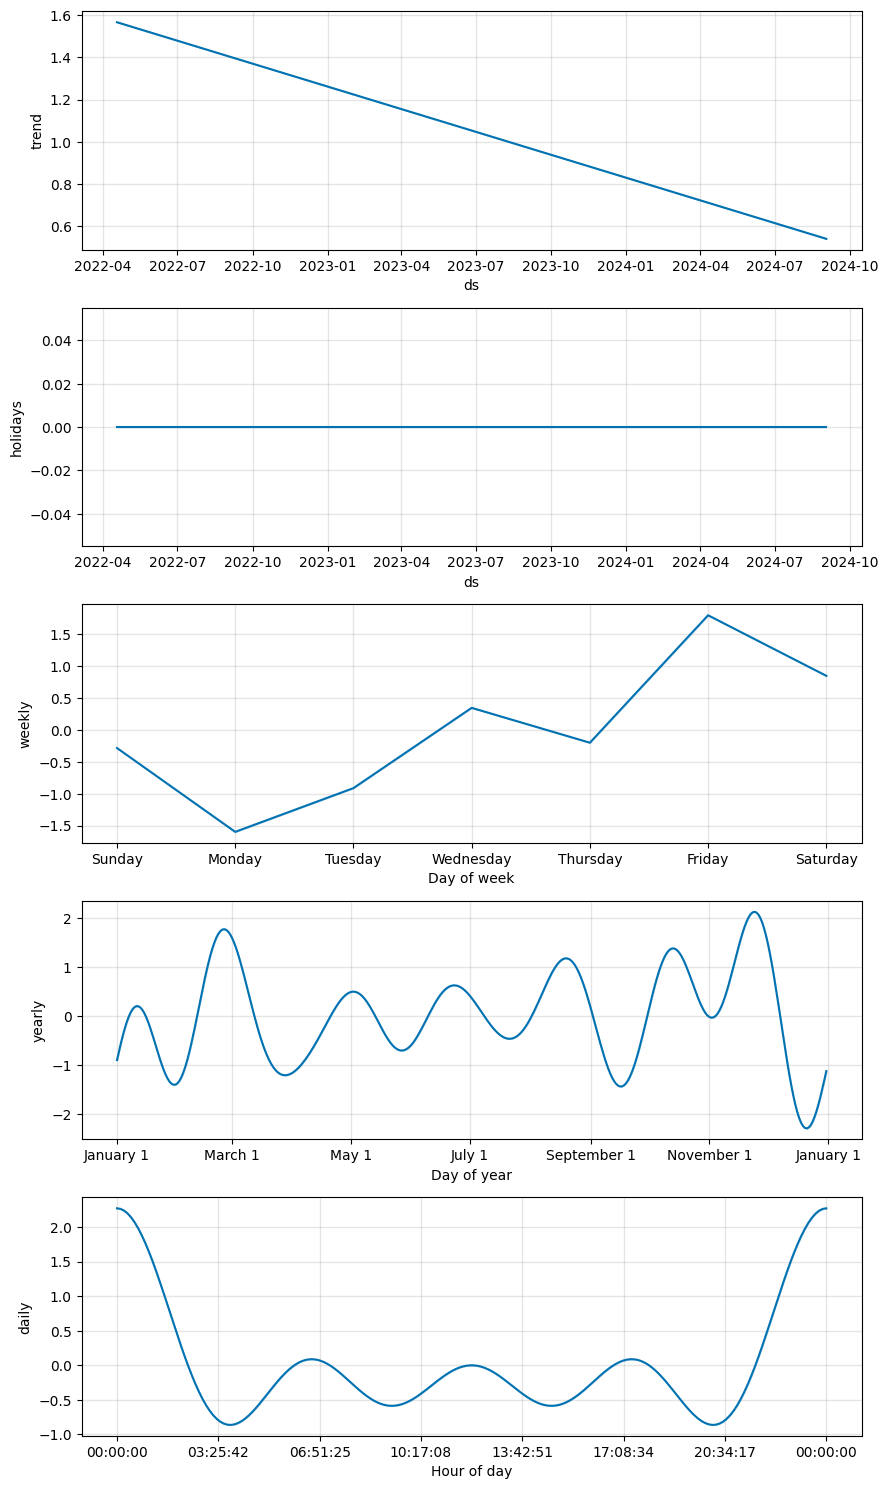

In [50]:
# Descompone y grafica los componentes de las predicciones (tendencia, estacionalidades, días festivos)
fig2 = m.plot_components(forecast)

In [51]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [52]:
plot_components_plotly(m, forecast)

#### Save model

In [58]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model_completo_v1.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('prophet_model_completo_v1.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [39]:
m = Prophet(growth='flat')

#### Metrics - MSE and RMSE

,actual,predicted
219,1.0,3.151984
220,11.0,3.428263
221,2.0,2.685462
222,2.0,4.061677
223,5.0,3.087617


Mean Squared Error (MSE): 8.434963819728987
Root Mean Squared Error (RMSE): 2.9043009175581282


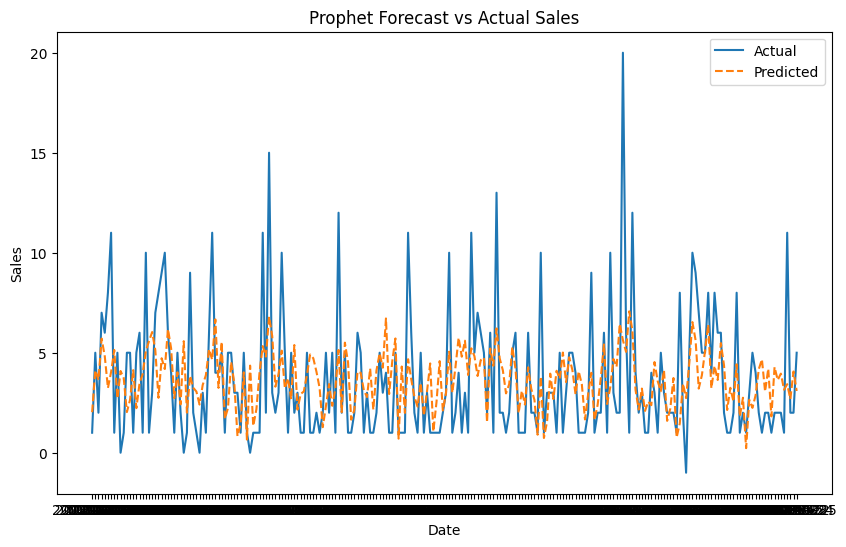

In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Extraer los valores reales y predichos para el cálculo del RMSE
y_true = df_prophet['y'].values  # Valores reales de ventas
y_pred = forecast['yhat'].iloc[:len(y_true)].values  # Predicciones del modelo Prophet

df_comparison = pd.DataFrame({
    'actual': y_true,
    'predicted': y_pred
})

# Si estás utilizando un entorno como Jupyter, puedes usar display para un mejor formato
from IPython.display import display
display(df_comparison.tail(5))

# Mostrar las métricas de error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Graficar las predicciones vs los valores reales (opcional)
plt.figure(figsize=(10, 6))
plt.plot(df_prophet['ds'], y_true, label='Actual')
plt.plot(df_prophet['ds'], y_pred, label='Predicted', linestyle='--')
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

#### Backtesting

In [54]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m, initial='365 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/1 [00:00<?, ?it/s]00:02:20 - cmdstanpy - INFO - Chain [1] start processing
00:02:20 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


In [55]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,11.188836,3.344972,2.937719,1.798434,0.880777,0.803927,0.909091
1,40 days,13.449298,3.667328,3.382417,2.243133,2.054466,0.925398,0.909091
2,42 days,17.397060,4.170978,3.823159,2.113409,0.880777,0.916397,0.818182
3,49 days,16.668725,4.082735,3.694409,1.830451,0.822548,0.849183,0.818182
4,50 days,20.491390,4.526742,4.153034,1.842557,0.880777,0.962594,0.727273
...,...,...,...,...,...,...,...,...
101,355 days,9.330125,3.054525,2.696220,1.714205,1.063829,0.906813,1.000000
102,358 days,18.352906,4.284029,3.476637,1.770390,1.063829,1.028574,0.909091
103,362 days,17.291745,4.158334,3.320401,1.788984,1.268358,0.917315,0.909091
104,364 days,17.277614,4.156635,3.314188,1.785877,1.268358,0.915431,0.909091


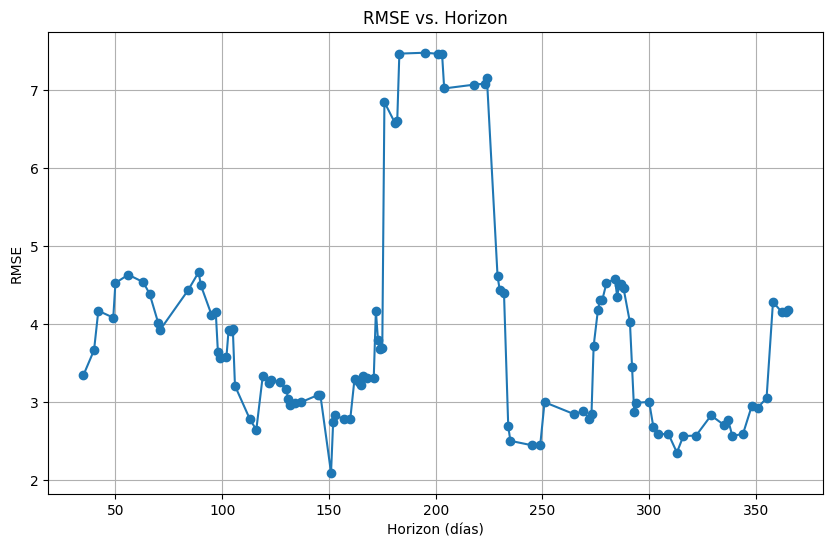

In [57]:
import matplotlib.pyplot as plt

# Asegurarte de que `horizon` esté en días (en caso de que esté en timedelta u otra unidad)
df_p['horizon'] = df_p['horizon'].dt.days  # Si 'horizon' está en formato timedelta

# Graficar el RMSE
plt.figure(figsize=(10, 6))
plt.plot(df_p['horizon'], df_p['rmse'], marker='o')
plt.title('RMSE vs. Horizon')
plt.xlabel('Horizon (días)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()